In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


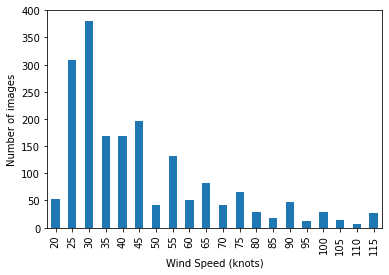

In [ ]:
image_dir = Path('/content/drive/MyDrive/Regression/data')

filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
intensity = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Intensity').astype(np.int32)

images = pd.concat([filepaths, intensity], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

image_df = images.sample(len(images), random_state=1).reset_index(drop=True)

train_df, val_df = train_test_split(image_df, test_size=0.3, shuffle=True, random_state=1)
val_df, test_df = train_test_split(val_df, test_size=0.5, shuffle=True, random_state=1)

train_labels = train_df.iloc[:, -1].values
val_labels = val_df.iloc[:, -1].values

images.Intensity.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Number of images')
plt.show()

In [ ]:
train_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, fill_mode='constant', cval=0)
val_generator = ImageDataGenerator(rescale = 1./255)
test_generator = ImageDataGenerator(rescale = 1./255)

train_images = train_generator.flow_from_dataframe(dataframe = train_df, x_col = 'Filepath', y_col = 'Intensity', target_size = (310, 310), class_mode = 'raw', batch_size = 2, shuffle = True)
val_images = train_generator.flow_from_dataframe(dataframe = val_df, x_col = 'Filepath', y_col = 'Intensity', target_size = (310, 310), class_mode = 'raw', batch_size = 1, shuffle = False)
test_images = test_generator.flow_from_dataframe(dataframe = test_df, x_col = 'Filepath', y_col = 'Intensity', target_size = (310, 310), class_mode = 'raw', batch_size = 1, shuffle = False)

Found 1308 validated image filenames.
Found 280 validated image filenames.
Found 281 validated image filenames.


# **VGG-16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16_model = VGG16(pooling = 'avg', weights = 'imagenet', include_top = False, input_shape = (310, 310, 3))

for layers in vgg16_model.layers:
    layers.trainable = False

last_output = vgg16_model.layers[-1].output

vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(1, activation = 'linear')(vgg_x)

vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(optimizer = 'adam', loss = 'mse')

# Create a checkpoint to save best weights
checkpoint = ModelCheckpoint('/content/drive/MyDrive/regression_vgg16_best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

history = vgg16_final_model.fit(train_images, validation_data=val_images, epochs=60, callbacks=[checkpoint, early_stopping, lr_scheduler], verbose=1)

In [ ]:
model = load_model('/content/drive/MyDrive/regression_vgg16_best_weights.h5')

plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

In [ ]:
test_images.reset()
predicted_intensity = np.squeeze(model.predict(test_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Test MAE: {:.2f}'.format(mae))

mse = mean_squared_error(true_intensity, predicted_intensity)
print('Test MSE: {:.2f}'.format(mse))

# **ResNet-50**

In [ ]:
ResNet50_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (310, 310, 3), classes=20)
for layers in ResNet50_model.layers:
    layers.trainable = True

resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256, activation='relu')(resnet50_x)
resnet50_x = Dense(1, activation = 'linear')(resnet50_x)
resnet50_x_final_model = Model(inputs = ResNet50_model.input, outputs = resnet50_x)

resnet50_x_final_model.compile(optimizer = 'adam', loss = 'mse')

# Create a checkpoint to save best weights
checkpoint = ModelCheckpoint('/content/drive/MyDrive/regression_resnet_best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

history = resnet50_x_final_model.fit(train_images, validation_data=val_images, epochs=60, callbacks=[checkpoint, early_stopping, lr_scheduler], verbose=1)

In [ ]:
model = load_model('/content/drive/MyDrive/regression_resnet_best_weights.h5')

plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

test_images.reset()
predicted_intensity = np.squeeze(model.predict(test_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Test MAE: {:.2f}'.format(mae))

mse = mean_squared_error(true_intensity, predicted_intensity)
print('Test MSE: {:.2f}'.format(mse))

# **InceptionV3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
InceptionV3_model = InceptionV3(input_shape = (310, 310, 3), weights = 'imagenet', include_top = False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True

InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation = 'relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(1, activation = 'linear')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs = InceptionV3_model.input, outputs = InceptionV3_x)

InceptionV3_x_final_model.compile(optimizer = 'adam', loss = 'mse')

# Create a checkpoint to save best weights
checkpoint = ModelCheckpoint('/content/drive/MyDrive/regression_inception_best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

history = InceptionV3_x_final_model.fit(train_images, epochs = 40, validation_data = val_images, verbose = 1, callbacks =[checkpoint, early_stopping, lr_scheduler])

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/40
654/654 [==============================] - 725s 1s/step - loss: 908.9748 - val_loss: 369.4290 - lr: 0.0010
Epoch 2/40
654/654 [==============================] - 60s 92ms/step - loss: 403.5289 - val_loss: 559.3687 - lr: 0.0010
Epoch 3/40
654/654 [==============================] - 70s 108ms/step - loss: 370.9918 - val_loss: 322.1306 - lr: 0.0010
Epoch 4/40
654/654 [==============================] - 63s 96ms/step - loss: 307.7923 - val_loss: 372.9999 - lr: 0.0010
Epoch 5/40
654/654 [==============================] - 69s 106ms/step - loss: 290.4800 - val_loss: 300.0946 - lr: 0.0010
Epoch 6/40
654/654 [==============================] - 60s 91ms/step - loss: 252.7568 - val_loss: 419.9787 - lr: 0.0010
Epoch 7/40
654/654 [==============================] - 55s 84ms/step - loss: 235.4101 - val_loss: 394.3078 - lr: 0.0010
Epoch 8/40
654/654 [==============================] - 55s 84ms/step - loss: 221.9267 - val_loss: 320.

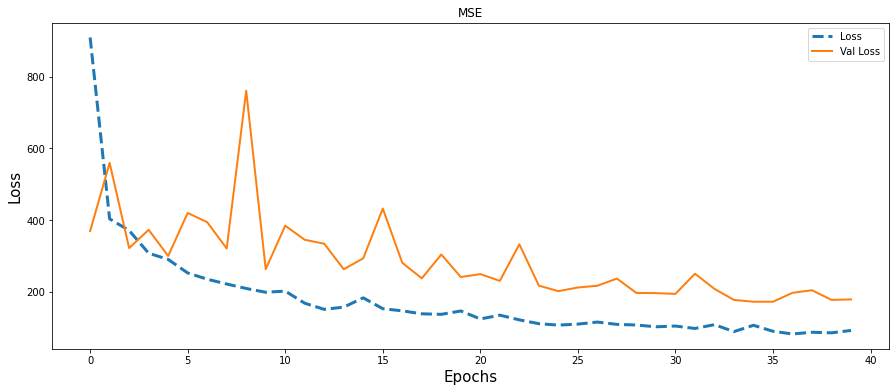

In [ ]:
model = load_model('/content/drive/MyDrive/regression_inception_best_weights.h5')

plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

280/280 [==============================] - 11s 36ms/step
Validation RMSE: 13.16044
Standard deviation in predicted validation intensities: 17.404558
Validation MSE: 163.70
Validation MAE: 9.60


In [ ]:
test_images.reset()
predicted_intensity = np.squeeze(model.predict(test_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Test MAE: {:.2f}'.format(mae))

mse = mean_squared_error(true_intensity, predicted_intensity)
print('Test MSE: {:.2f}'.format(mse))

281/281 [==============================] - 116s 416ms/step
     Test RMSE: 12.10190
Test MAE: 8.96
Test MSE: 146.46


# **XceptionNet**

In [ ]:
from tensorflow.keras.applications.xception import Xception
xception_model = Xception(include_top = False, weights = "imagenet", input_shape = (310, 310, 3))
x = Flatten()(xception_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(1, activation = 'linear')(x)

xception_final_model = Model(inputs = xception_model.input, outputs = x)

xception_final_model.compile(optimizer = 'adam', loss = 'mse')

# Create a checkpoint to save best weights
checkpoint = ModelCheckpoint('/content/drive/MyDrive/regression_xception_best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
history = xception_final_model.fit(train_images, validation_data = val_images, epochs = 30, callbacks =[checkpoint, early_stopping, lr_scheduler], verbose = 1)

Epoch 1/30
654/654 [==============================] - 134s 163ms/step - loss: 723.4185 - val_loss: 611.6491 - lr: 0.0010
Epoch 2/30
654/654 [==============================] - 66s 101ms/step - loss: 573.8243 - val_loss: 622.9326 - lr: 0.0010
Epoch 3/30
654/654 [==============================] - 68s 104ms/step - loss: 548.4269 - val_loss: 1909.4310 - lr: 0.0010
Epoch 4/30
654/654 [==============================] - 67s 102ms/step - loss: 551.8872 - val_loss: 22288.2520 - lr: 0.0010
Epoch 5/30
654/654 [==============================] - 70s 107ms/step - loss: 516.5533 - val_loss: 488436.4062 - lr: 0.0010
Epoch 6/30
654/654 [==============================] - 68s 104ms/step - loss: 535.8512 - val_loss: 984.1370 - lr: 0.0010
Epoch 7/30
654/654 [==============================] - 77s 117ms/step - loss: 412.5834 - val_loss: 545.1655 - lr: 1.0000e-04
Epoch 8/30
654/654 [==============================] - 76s 117ms/step - loss: 358.2182 - val_loss: 436.2422 - lr: 1.0000e-04
Epoch 9/30
654/654 [=====

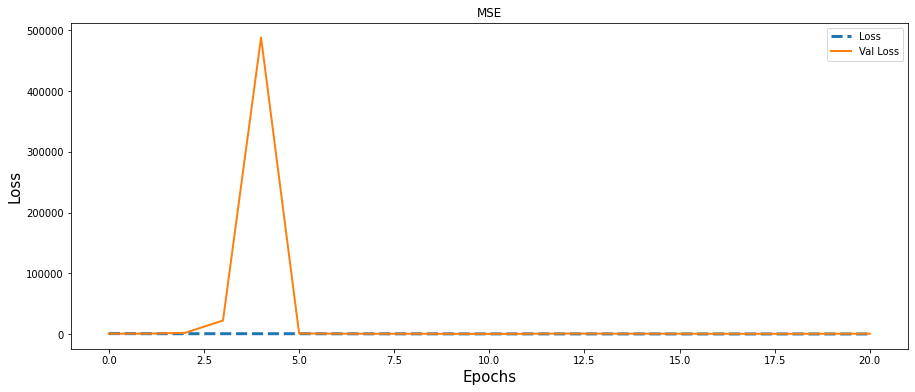

In [ ]:
model = load_model('/content/drive/MyDrive/regression_xception_best_weights.h5')

plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose = 0))
print("Validation RMSE: {:.5f}".format(rmse))

print('Standard deviation in predicted validation intensities:', np.std(predicted_intensity))
mse = mean_squared_error(true_intensity, predicted_intensity)
print('Validation MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Validation MAE: {:.2f}'.format(mae))

280/280 [==============================] - 9s 27ms/step
Validation RMSE: 17.38191
Standard deviation in predicted validation intensities: 20.304522
Validation MSE: 282.51
Validation MAE: 12.77


In [ ]:
test_images.reset()
predicted_intensity = np.squeeze(model.predict(test_images))
#predicted_intensity = np.round(predicted_intensity/5, 0)*5
true_intensity = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

mae = mean_absolute_error(true_intensity, predicted_intensity)
print('Test MAE: {:.2f}'.format(mae))

mse = mean_squared_error(true_intensity, predicted_intensity)
print('Test MSE: {:.2f}'.format(mse))

281/281 [==============================] - 3s 12ms/step
     Test RMSE: 23.72987
Test MAE: 18.92
Test MSE: 563.11


# **AlexNet**

In [ ]:
class AlexNet(Sequential):
    def __init__(self, input_shape):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(1, activation= 'linear'))

        self.compile(optimizer= 'adam',loss='mse')

In [ ]:
model = AlexNet((310, 310, 3))

In [ ]:
history = model.fit(train_images, epochs=40, validation_data=val_images, verbose=1)

Epoch 1/40
654/654 [==============================] - 54s 76ms/step - loss: 4866.6733 - val_loss: 1489.2332
Epoch 2/40
654/654 [==============================] - 50s 76ms/step - loss: 618.4311 - val_loss: 479.0140
Epoch 3/40
654/654 [==============================] - 51s 77ms/step - loss: 516.0378 - val_loss: 430.8745
Epoch 4/40
654/654 [==============================] - 49s 74ms/step - loss: 475.1461 - val_loss: 405.5984
Epoch 5/40
654/654 [==============================] - 51s 77ms/step - loss: 480.5292 - val_loss: 452.5797
Epoch 6/40
654/654 [==============================] - 48s 74ms/step - loss: 456.6551 - val_loss: 365.3837
Epoch 7/40
654/654 [==============================] - 50s 77ms/step - loss: 429.0758 - val_loss: 525.3891
Epoch 8/40
142/654 [=====>........................] - ETA: 29s - loss: 420.7920

In [ ]:
model.save('/content/drive/MyDrive/alexnet__regression_model.hdf5')

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(history.history['loss'], lw = 3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw = 2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('MSE')
plt.legend();

In [ ]:
val_images.reset()
predicted_intensity = np.squeeze(model.predict(val_images))
true_intensity = val_images.labels

rmse = np.sqrt(model.evaluate(val_images, verbose=0))
print("Validation RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_intensity, predicted_intensity)
print("Validation R^2 Score: {:.5f}".format(r2))

# **Proposed Model**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (310, 310, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dropout(0.4))

model.add(Dense(units = 512, activation = 'relu'))

model.add(Dropout(0.3))

model.add(Dense(1, activation = 'linear'))

In [ ]:
print("{0:5} {1:10} {2}".format("True", "Predicted", "Filenames"))
for i in range(len(predicted_intensity[:96])):
    print("{0:5} {1:10} {2}".format(true_intensity[i], int(predicted_intensity[i]), test_images.filenames[i]))

True  Predicted  Filenames
   75         40 /content/drive/MyDrive/Regression/test_2022_2021/75/20210526.06-75.jpg
   35         35 /content/drive/MyDrive/Regression/test_2022_2021/35/20210925.12-35.jpg
   40         45 /content/drive/MyDrive/Regression/test_2022_2021/40/20210515.00-40.jpg
   95         75 /content/drive/MyDrive/Regression/test_2022_2021/95/20210517.12-95.jpg
   25         50 /content/drive/MyDrive/Regression/test_2022_2021/25/20220507.06-25.jpg
   60         50 /content/drive/MyDrive/Regression/test_2022_2021/60/20211003.12-60.jpg
   65         45 /content/drive/MyDrive/Regression/test_2022_2021/65/20210525.12-65.jpg
  100         85 /content/drive/MyDrive/Regression/test_2022_2021/100/20210517.06-100.jpg
   30         45 /content/drive/MyDrive/Regression/test_2022_2021/30/20210930.18-30.jpg
   60         40 /content/drive/MyDrive/Regression/test_2022_2021/60/20211002.06-60.jpg
   30         45 /content/drive/MyDrive/Regression/test_2022_2021/30/20210925.06-30.jpg
   

In [ ]:
import pandas as pd

# Create a DataFrame from the true intensity, predicted intensity, and filenames
data = {'True Intensity': true_intensity[:96], 'Predicted Intensity': predicted_intensity[:96], 'Filenames': test_images.filenames[:96]}
df = pd.DataFrame(data)

# Create a new column 'Class' in the DataFrame
df['Class'] = np.where((df['True Intensity'] >= 20) & (df['True Intensity'] <= 25), 'D',
                      np.where((df['True Intensity'] >= 30) & (df['True Intensity'] <= 35), 'DD',
                               np.where((df['True Intensity'] >= 40) & (df['True Intensity'] <= 50), 'CS',
                                        np.where((df['True Intensity'] >= 55) & (df['True Intensity'] <= 65), 'SCS', 'VSCS'))))
# Save the DataFrame to an Excel file
df.to_excel("intensity_predictions.xlsx")


# **Testing using direct images**

In [ ]:
binary_model = load_model('/content/drive/MyDrive/stacked_binary.hdf5')
regression_model = load_model('/content/drive/MyDrive/proposed_regression_model.hdf5')

path = '/content/drive/MyDrive/cyclone_testing/20220507.00-20.jpg'
img = image.load_img(path, target_size = (310, 310))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
images = np.vstack([x])
classes = binary_model.predict(images)
if classes[0] < 0.5:
  print("\n Uploaded image doesn't have a cyclone \n")
else:
  print('Uploaded image has a cyclone')

path = '/content/drive/MyDrive/regression_data/regression_data/40/20090416.09-40.jpg'
img = image.load_img(path, target_size = (310, 310, 3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
images = np.vstack([x])
regression_prediction = regression_model.predict(images)
print('\nPredicted intensity of the cylone in the image :-', int(regression_prediction))